In [21]:
import os
import sys
import tempfile
import webbrowser

srcpath = os.path.realpath('SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from teproteus_functions_v3 import connect
from teproteus_functions_v3 import disconnect
from teproteus_functions_v3 import set_lib_dir_path
from teproteus_functions_v3 import get_cpatured_header
from teproteus_functions_v3 import gauss_env
from teproteus_functions_v3 import iq_kernel
from teproteus_functions_v3 import pack_kernel_data
from tevisainst import TEVisaInst

# matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import signal
from scipy.signal import fftconvolve
import math

In [22]:
# Proteus Parameters
max_dac         = 2**16 - 1                                                        # Max DAC Value
half_dac        = np.round(max_dac/2)
wav_data_type   = np.uint16

# MArk Data Type
mark_max_dac    = 2**8 - 1                                                         # Max DAC Value for Mark Data
mark_half_dac   = np.round(mark_max_dac/2)
mark_data_type  = np.uint8

# Proteus AWG Parameters
chNum           = 1                                                                      # No. of Channels
granual         = 64                                                                     # Granularity of the DAC    
minLen          = 128                                                                    # Minimum Segments to be used in the AWG
segLen          = 2**12                                                                  # Length of the Segments to be used in the AWG, this should in multiple of Granularity

# AWG Setting Parameters
sampleRate      = 9.0E+9                                                                 # Sampling Rate
OUTPV           = 0.50                                                                   # Channel O/P Voltage

In [23]:
# Connect to instrument

pid = os.getpid()
print('process id {0}'.format(pid))

proteus_addr = 'TCPIP::169.254.103.249::5025::SOCKET'

try:
    proteus = TEVisaInst(proteus_addr)
except TEVisaInst.Error as ex1:
    print('Could not connect to %s', proteus_addr)
    sys.exit()

proteus.default_paranoia_level = 2 # Set the default paranoia-level (0, 1 or 2)

# Clear reset the instrument
proteus.send_scpi_cmd('*CLS; *RST')

# Instrument's identification and slot details
resp = proteus.send_scpi_query(":SYST:ERR?")  #To check system error-list
print(resp)
resp = proteus.send_scpi_query('*IDN?')
print('Connected to: ' + resp)

# Get the model:
model_name = proteus.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get number of channels
num_channels = int(proteus.send_scpi_query(':INST:CHAN? MAX'))
print('Number of channels: {}'.format(num_channels))

process id 26180
0, no error
Connected to: Tabor Electronics,P9484D,000002210902,1.240.35 --slot#: 5, 
Model: P9484D 
Number of channels: 4


Waveform Length: 4096
Marker Length: 512


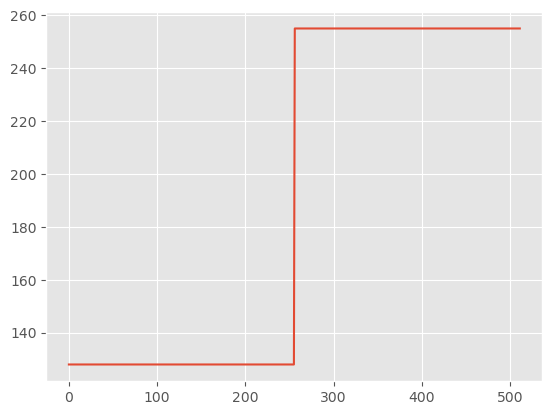

In [24]:
# Generate the waveform

wav = np.zeros(segLen)  # Create the waveform array

wav   = (wav + 1.0) * half_dac
wav   = np.round(wav)
wav   = np.clip(wav, 0, max_dac)
wav   = wav.astype(wav_data_type)

# Generate Marker
markLen = int(segLen/8)
marker  = np.zeros(markLen)  # Create the marker array

for i in range(0, markLen):
    if i < (markLen / 2):
        marker[i] = 0
    else:
        marker[i] = 1

marker = (marker + 1.0) * mark_half_dac
marker = np.round(marker)
marker = np.clip(marker, 0, mark_max_dac)
marker = marker.astype(mark_data_type)

print('Waveform Length: {}'.format(len(wav)))
print('Marker Length: {}'.format(len(marker)))
plt.plot(marker)

In [ ]:
# Download the waveform to the selected segment
proteus.send_scpi_cmd(':INST:CHAN {0}'.format(chNum)) # Select channel
proteus.send_scpi_cmd(':TRAC:DEF 1, {0}' .format(len(wav)))
proteus.send_scpi_cmd(':TRAC:SEL 1')
proteus.write_binary_data(':TRAC:DATA', wav)
resp = proteus.send_scpi_query(':SYST:ERR?')
print(resp)

# Doanload the marker to the selected segment
# Select the channel
proteus.send_scpi_cmd(':INST:CHAN 1')
# Select the marker
proteus.send_scpi_cmd(':MARK:SEL 1')
# Download the marker data
proteus.write_binary_data(':MARK:DATA', marker)

# Select the channel
proteus.send_scpi_cmd(':INST:CHAN 1')

# Select the Marker
proteus.send_scpi_cmd(':MARK:SEL 1')

# Set Marker Peak to Peak Voltage
proteus.send_scpi_cmd(':MARK:VOLT:PTOP 1.0')

# Set Marker Offset Voltage
proteus.send_scpi_cmd(':MARK:VOLT:OFFS 0.0')

# Turn on the marker
proteus.send_scpi_cmd(':MARK ON') 
resp = proteus.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error
0, no error


In [ ]:
# Select the module
proteus.send_scpi_cmd(':INST:ACT:SEL 1') # Select Master module
proteus.send_scpi_cmd(':INST:CHAN {0}'.format(chNum)) # Select channel
proteus.send_scpi_cmd(':SOUR:FREQ:RAST {0}'.format(sampleRate))

# Set the task to play chirp signal
proteus.send_scpi_cmd(':INST:CHAN {0}'.format(chNum)) # Select channel
proteus.send_scpi_cmd(':FUNC:MODE:SEGM {0}'.format(chNum)) # Select segment mode

# Set ouput voltage
proteus.send_scpi_cmd('VOLT {0}'.format(OUTPV))

# Switch on output
proteus.send_scpi_cmd(':OUTP ON') # O/P ON

0

In [ ]:
disconnect()